In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emcee
from corner import corner
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

In [83]:
from scipy.stats import poisson, nbinom, norm, chi2
from scipy.optimize import fmin, minimize
import emcee

In [7]:
df = pd.read_csv('../data/mtDNA_counts.txt', sep='\t', index_col=0, header=None)
df.columns = ['locus', 'count']
df

,locus,count
0,,
1,577,0
2,578,0
3,579,0
4,580,0
5,581,0
...,...,...
15443,16019,0
15444,16020,0
15445,16021,0


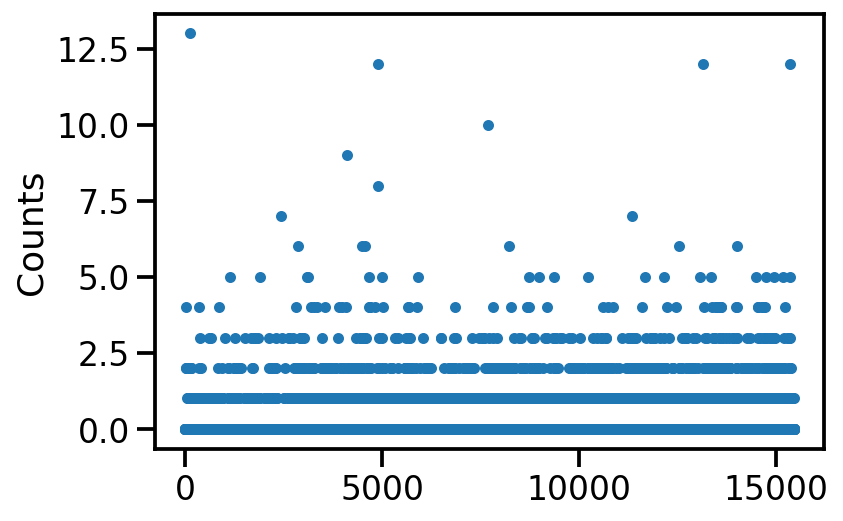

In [70]:
X = df['count']
plt.plot(X, '.')
plt.ylabel('Counts');

# Poisson model

$$
X_i \sim \text{Poi}(\lambda)
$$

In [9]:
def poisson_log_likelihood(λ):    
    return poisson.logpmf(X, λ).sum()

def poisson_log_prior(λ):
    if λ > 0: return 0
    return -np.inf
    
def poisson_log_posterior(λ):
    pri = poisson_log_prior(λ)
    if not np.isfinite(pri): return pri
    return pri + poisson_log_likelihood(λ)

In [33]:
nwalkers = 50
nsteps = 500

poisson_sampler = emcee.EnsembleSampler(nwalkers, 1, poisson_log_posterior)

λ_guesses = np.random.exponential(X.mean(), size=(nwalkers, 1))
poisson_sampler.run_mcmc(λ_guesses, nsteps);

In [34]:
λ_sample = poisson_sampler.chain[:, nsteps//2:, :].reshape(-1, 1)

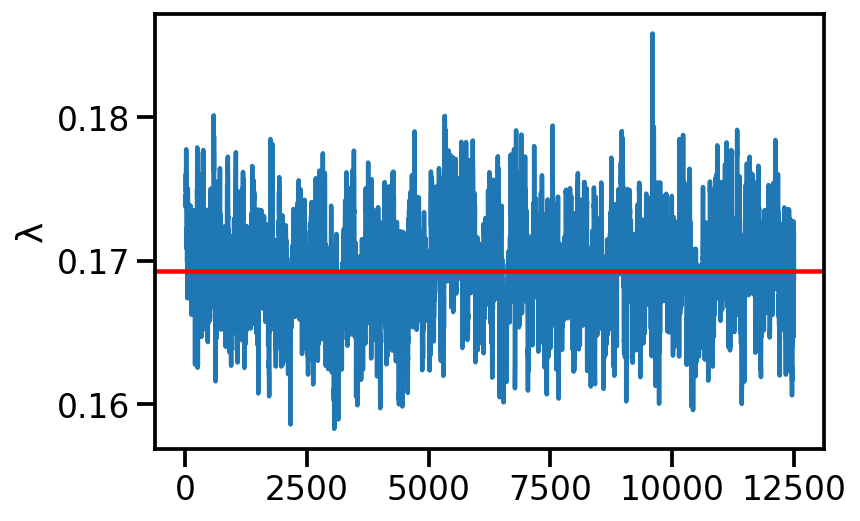

In [35]:
plt.plot(λ_sample)
plt.axhline(λ_sample.mean(), color=red)
plt.ylabel('λ');

λ_hat = 0.169


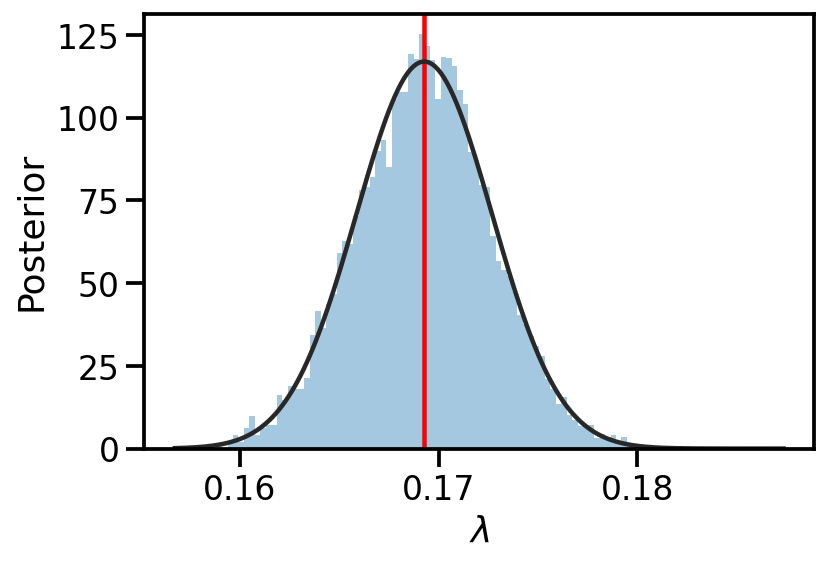

In [44]:
λ_hat = λ_sample.mean()
print('λ_hat = {:.3f}'.format(λ_hat))
plt.axvline(λ_hat, color=red)
sns.distplot(λ_sample.ravel(), 100, kde=False, fit=norm)
plt.xlabel('$\lambda$')
plt.ylabel('Posterior');

# Negative binomial model

$$
\lambda_i \sim \Gamma(\alpha, \beta) \\
X_i \sim \text{Poi}(\lambda_i) \Rightarrow \\
X_i \sim \text{NB}\Big(\alpha, \frac{1}{1+\beta}\Big)
$$

In [10]:
def nbinom_log_likelihood(θ):
    α, β = θ
    n = α
    p = 1/(β+1)
    return nbinom.logpmf(X, n, p).sum()

def nbinom_log_prior(θ):
    α, β = θ
    if α > 0 and β > 0: return 0
    return -np.inf
    
def nbinom_log_posterior(θ):
    pri = nbinom_log_prior(θ)
    if not np.isfinite(pri): return pri
    return pri + nbinom_log_likelihood(θ)

In [38]:
nbinom_sampler = emcee.EnsembleSampler(nwalkers, 2, nbinom_log_posterior)

# n_guesses = np.random.choice(X+1, size=nwalkers)
# p_guesses = X.mean() + np.random.normal(0, 0.01, size=nwalkers)
# θ_guesses = np.array([n_guesses, p_guesses]).T
θ_guesses = np.random.exponential(X.mean(), size=(nwalkers, 2))
nbinom_sampler.run_mcmc(θ_guesses, nsteps);

In [45]:
θ_sample = nbinom_sampler.chain[:, nsteps//2:, :].reshape(-1, 2)
α_sample = θ_sample[:,0]
β_sample = θ_sample[:,1]

α_hat = 0.168
β_hat = 1.010


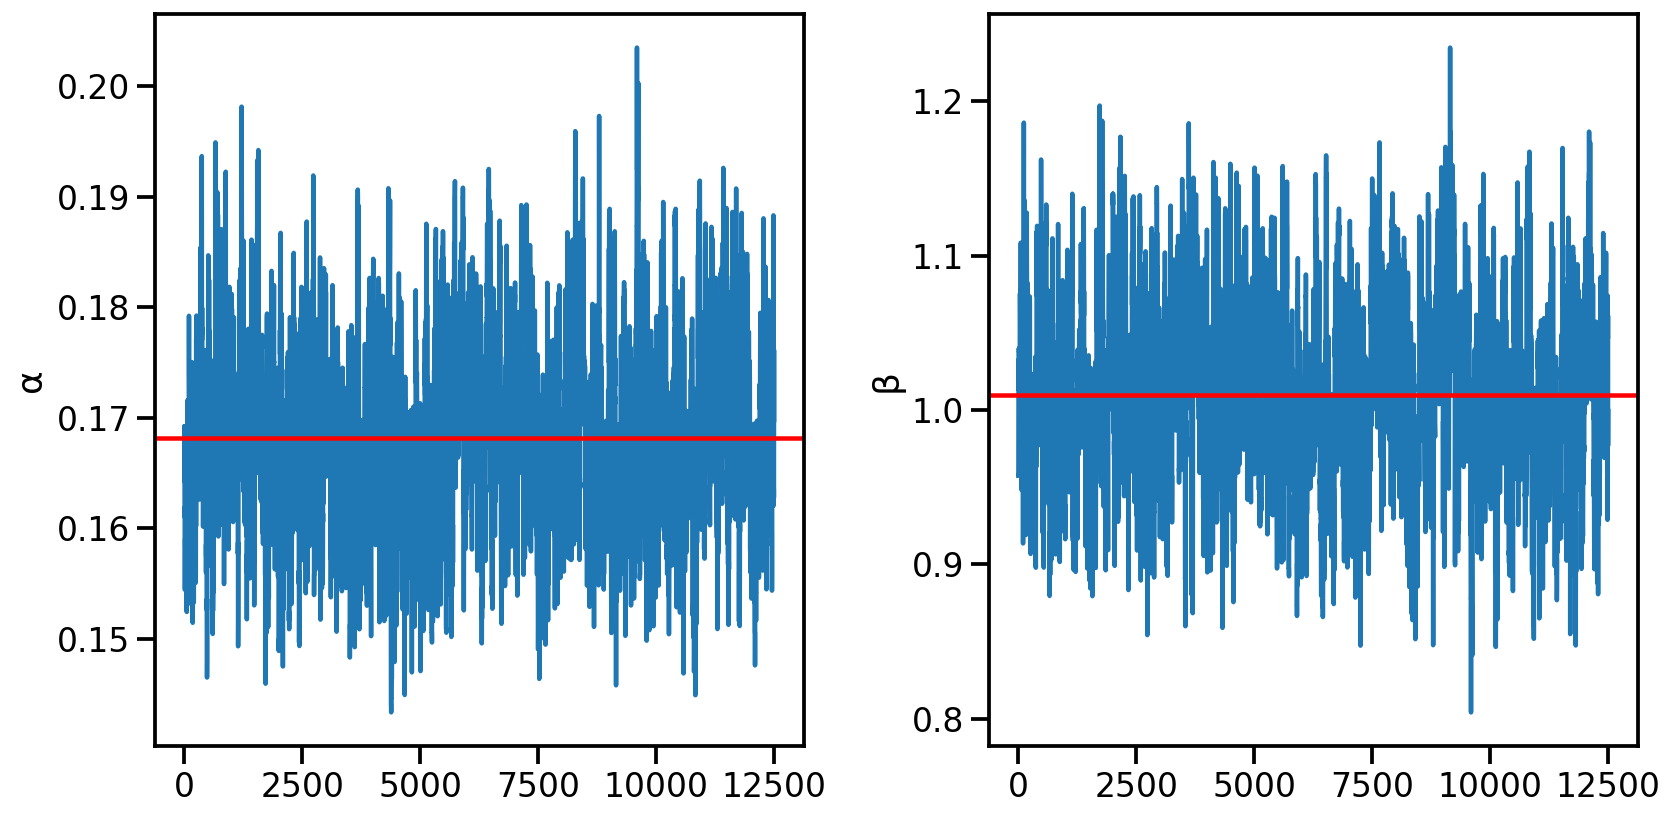

In [49]:
α_hat = α_sample.mean()
β_hat = β_sample.mean()
print('α_hat = {:.3f}'.format(α_hat))
print('β_hat = {:.3f}'.format(β_hat))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for sample, label, ax in zip([α_sample, β_sample], ['α', 'β'], axes):
    ax.plot(sample)
    ax.axhline(sample.mean(), color=red)
    ax.set_ylabel(label)
fig.tight_layout()

NoneType

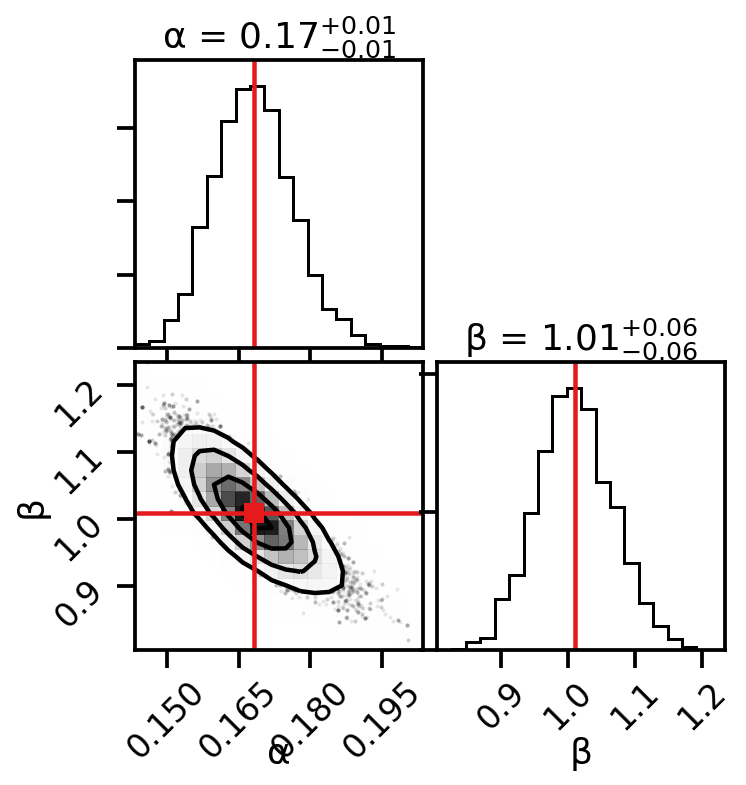

In [79]:
cor = corner(θ_sample,
    smooth=True,
    labels=['α', 'β'],
    show_titles=True,
    truths=[α_hat, β_hat],
    truth_color=red,
)

# Model comparison

## General likelihood ratio test

In cases where the two models are nested, we can use the general likelihood ratio test.

Here, the models are nested, as 
$$
\text{Poi}(\lambda) = \lim_{\alpha \to \infty} \text{NB}\Big(\alpha, \frac{1}{1+\lambda/\alpha}\Big)
$$
So negative binomial can be reduced to a Poisson by taking $\alpha$ to be very large and taking $\beta$ to be $\beta=\lambda/\alpha$.

When the models are nested we can compute $G$ as a function of the log-likelihoods of the models, and then $G$ will be $\chi^2$ distributed, where the degrees of freedom of the distribution is the difference in number of parameters (in this case, `df=1`).

$$
G = -2\log\Big(\frac{\mathcal{L}(\text{Poi})}{\mathcal{L}(\text{NB})}\Big) = -2 \big(\log\mathcal{L}(\text{Poi}) - \log\mathcal{L}(\text{NB})\big) \\
G \sim \chi_1^2
$$

In [141]:
ll_poisson = poisson_log_likelihood(λ_hat)
ll_nbinom = nbinom_log_likelihood((α_hat, β_hat))
G = -2 * (ll_poisson - ll_nbinom)
pvalue = chi2.sf(G, 1)
print("G={:.2f}, p-value={:.2g}".format(G, pvalue))

G=2171.88, p-value=0


We see conclusive support for the negative binomical model.

## DIC

DIC, or deviance information criterion, is a more genreal model selection criterion that can be used even if models are not nested. 
Moreover, it uses not just the likelihood of the MAP, but also the of the entire posterior.
This allows DIC to represent model complexity in a more sophisticated way then just the difference in the number of parameters. 
See references for a more elaborate discussion.

The DIC is computed in the following way:

$$
D(\theta) = -2\log\mathcal{L}(\theta) \\
DIC = 2 \mathbb{E}[D(\theta)] - D(\mathbb{E}[\theta]) = \\ 
2 \mathbb{E}[-2\log\mathcal{L}(\theta)] + 2\log\mathcal{L}(\mathbb{E}[\theta]) = \\
-4 \mathbb{E}[\log\mathcal{L}(\theta)] + 2\log\mathcal{L}(\mathbb{E}[\theta]) = \\
$$

where $\theta$ is the model parameters and expectation ($\mathbb{E}$) is taken over the posterior of $\theta$.

Note that 
- $\log\mathcal{L}(\mathbb{E}[\theta])$ is the log-likelihood at the expected $\theta$, which we have computed before at $\hat{\theta}$.
- $\mathbb{E}[\log\mathcal{L}(\theta)]$ is the expected log-likelihood over the posterior of $\theta$, which we can compute by taking the mean of the log-likelihood of the posterior samples. These log-likelihoods have already been computed by the sampler, so we can reuse them.
- With DIC (as with AIC and BIC), **lower is better**.
- As a rule of thumb, a difference of 6 or more is considered strong evidence, whereas a difference of less than 2 is considered not worth mentioning.

In [129]:
E_ll_poisson = poisson_sampler.lnprobability[:, nsteps//2:].mean()
E_ll_nbinom = nbinom_sampler.lnprobability[:, nsteps//2:].mean()

In [132]:
DIC_poisson = -4*E_ll_poisson + 2*ll_poisson
DIC_nbinom = -4*E_ll_nbinom + 2*ll_nbinom
print("DIC(Poi) = {:.2f}".format(DIC_poisson))
print("DIC(NB) = {:.2f}".format(DIC_nbinom))
print("DIC(Poi)-DIC(NB) = {}".format(DIC_poisson - DIC_nbinom))

DIC(Poi) = 16258.08
DIC(NB) = 14088.22
DIC(Poi)-DIC(NB) = 2169.856921536035


We see very strong support for the negative binomical model.

# References

- [Penalized loss functions for Bayesian model comparison](https://academic.oup.com/biostatistics/article/9/3/523/224568)
- [Bayesian measures of model complexity and fit](https://doi.org/10.1111/1467-9868.00353)